# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [ ]:
# Install required libraries
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


We load required models:
* dalle·mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

### Dalle Model Function

In [ ]:
def dalle_func(input_text):
  #summarizer part
  from transformers import pipeline

  #call model from github and define summarization pipeline
  summarizer = pipeline("summarization", model="linydub/bart-large-samsum")

  #summarize text
  result = summarizer(input_text)

  #return result
  summ = result[0]['summary_text']

  #dalle part
  #cell 1
  # Model references
  # dalle-mini
  DALLE_MODEL = "dalle-mini/dalle-mini/kvwti2c9:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
  DALLE_COMMIT_ID = None

  # dalle-mega - comment this line if your hardware runs out of memory to use dalle-mini instead
  DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"

  # VQGAN model
  VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
  VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

  # CLIP model
  CLIP_REPO = "openai/clip-vit-large-patch14"
  CLIP_COMMIT_ID = None

  #cell 2
  import jax
  import jax.numpy as jnp

  # check how many devices are available
  jax.local_device_count()

  #cell 3
  # Load models & tokenizer
  from dalle_mini import DalleBart, DalleBartProcessor
  from vqgan_jax.modeling_flax_vqgan import VQModel
  from transformers import CLIPProcessor, FlaxCLIPModel

  # Load dalle-mini
  model, params = DalleBart.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False)

  # Load VQGAN
  vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

  # Load CLIP
  clip = FlaxCLIPModel.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
  clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)

  #cell 4
  from flax.jax_utils import replicate

  params = replicate(params)
  vqgan._params = replicate(vqgan.params)
  clip._params = replicate(clip.params)

  #cell 5
  from functools import partial

  # model inference
  @partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
  def p_generate(
      tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
  ):
      return model.generate(
          **tokenized_prompt,
          prng_key=key,
          params=params,
          top_k=top_k,
          top_p=top_p,
          temperature=temperature,
          condition_scale=condition_scale,
      )


  # decode image
  @partial(jax.pmap, axis_name="batch")
  def p_decode(indices, params):
      return vqgan.decode_code(indices, params=params)


  # score images
  @partial(jax.pmap, axis_name="batch")
  def p_clip(inputs, params):
      logits = clip(params=params, **inputs).logits_per_image
      return logits

  #cell 6
  import random

  # create a random key
  seed = random.randint(0, 2**32 - 1)
  key = jax.random.PRNGKey(seed)

  #cell 7
  from dalle_mini import DalleBartProcessor

  processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

  #cell 8
  prompt = summ
  tokenized_prompt = processor([prompt])

  #cell 9
  tokenized_prompt = replicate(tokenized_prompt)

  #cell 10
  # number of predictions
  n_predictions = 16

  # We can customize top_k/top_p used for generating samples
  gen_top_k = None
  gen_top_p = None
  temperature = None
  cond_scale = 3.0

  #cell 11
  from flax.training.common_utils import shard_prng_key
  import numpy as np
  from PIL import Image
  from tqdm.notebook import trange

  # generate images
  images = []
  for i in trange(max(n_predictions // jax.device_count(), 1)):
      # get a new key
      key, subkey = jax.random.split(key)
      # generate images
      encoded_images = p_generate(
          tokenized_prompt,
          shard_prng_key(subkey),
          params,
          gen_top_k,
          gen_top_p,
          temperature,
          cond_scale,
      )
      # remove BOS
      encoded_images = encoded_images.sequences[..., 1:]
      # decode images
      decoded_images = p_decode(encoded_images, vqgan.params)
      decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
      for img in decoded_images:
          images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  #cell 12
  from flax.training.common_utils import shard

  # get clip scores
  clip_inputs = clip_processor(
      text=[prompt] * jax.device_count(),
      images=images,
      return_tensors="np",
      padding="max_length",
      max_length=77,
      truncation=True,
  ).data
  logits = p_clip(shard(clip_inputs), clip.params)
  logits = logits.squeeze().flatten()

  #cell 13
  print(f"Prompt: {prompt}\n")
  for idx in logits.argsort()[::-1]:
      display(images[idx])
      print(f"Score: {logits[idx]:.2f}\n")

Downloading:   0%|          | 0.00/1.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Your max_length is set to 62, but you input_length is only 42. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=21)
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:0
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmpww2nw_rb:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxB

  0%|          | 0/16 [00:00<?, ?it/s]

Prompt: Someone brought me a long cream colored limousine. I drive it up a country road.



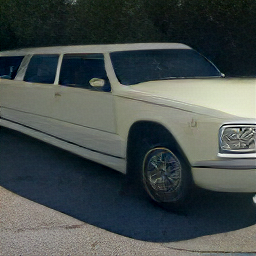

Score: 31.33



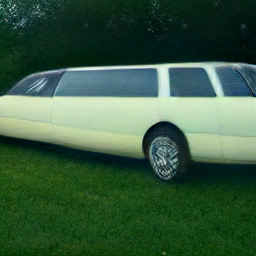

Score: 30.90



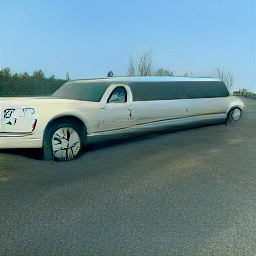

Score: 30.38



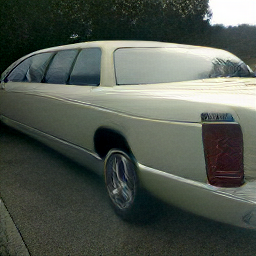

Score: 29.88



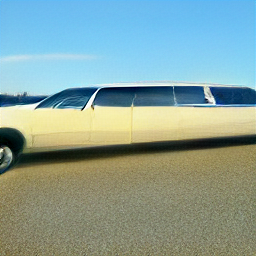

Score: 29.62



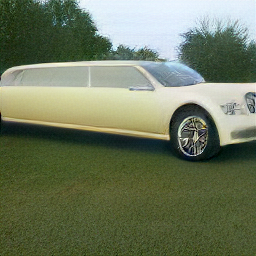

Score: 29.35



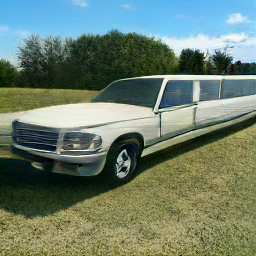

Score: 29.16



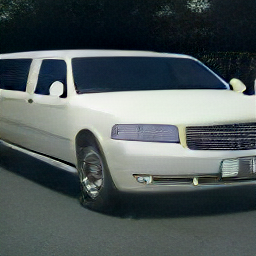

Score: 28.70



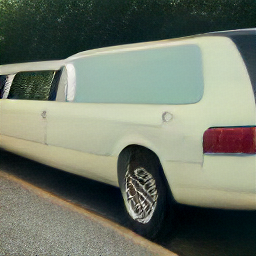

Score: 28.40



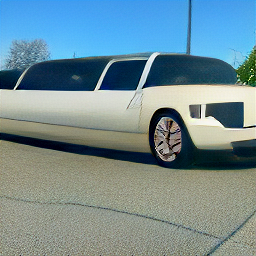

Score: 28.40



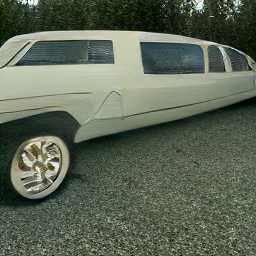

Score: 27.88



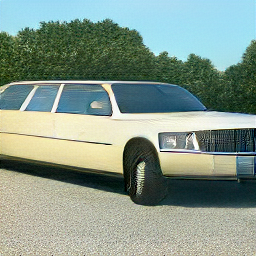

Score: 27.44



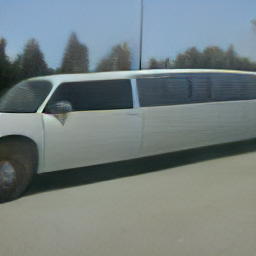

Score: 26.83



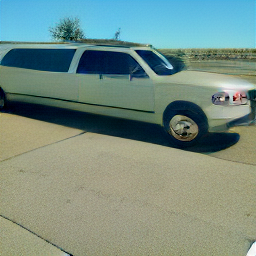

Score: 26.62



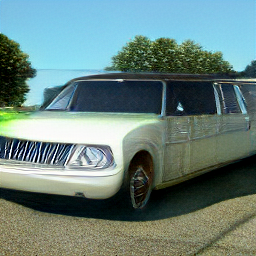

Score: 23.44



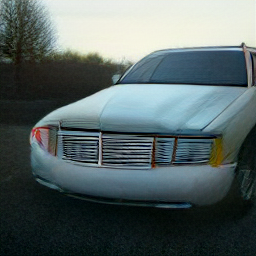

Score: 21.42



In [ ]:
dalle_func('Someone brought me a long cream colored limousine. I get in the drivers seat. I drive up a country road, mud and gravel and then turn, finding I can drive it with ease.')